In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [0]:
import os
os.chdir("/content/drive/ITM/Extensión/DeepLearning/2018_2Convolucionales UNAL/")

In [0]:
!ls

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

    100% |████████████████████████████████| 993kB 18.9MB/s 


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default() 

y = 1
Número de ejemplos de entrenamiento: 824
Número de ejemplos de testing: 206
X_train shape: (824, 224, 224, 3)
Y_train shape: (824, 4)
X_test shape: (206, 224, 224, 3)
Y_test shape: (206, 4)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.388375
Train Accuracy: 0.45024273
Test Accuracy: 0.3106796
Train Accuracy: 0.58980584
Test Accuracy: 0.4563107
Train Accuracy: 0.6686893
Test Accuracy: 0.5291262

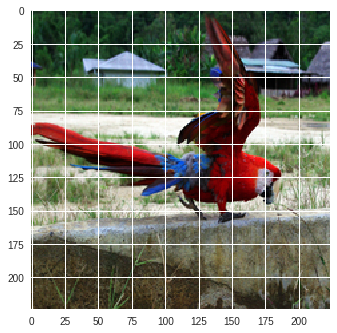

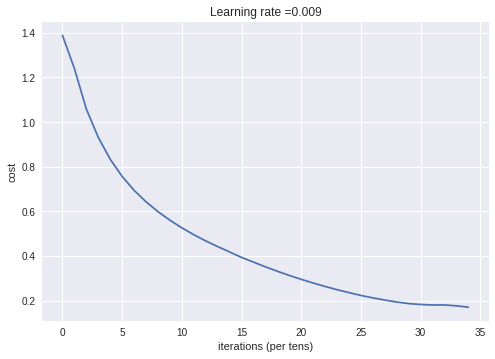

In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils1 import *

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()      # Cargar la base de datos

# Visualizar uno de los ejemplos de la base de datos

index = 6
plt.figure(1)
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))



# imprimir características de la base de datos
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 4).T
Y_test = convert_to_one_hot(Y_test_orig, 4).T
print ("Número de ejemplos de entrenamiento: " + str(X_train.shape[0]))
print ("Número de ejemplos de testing: " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}



def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Crea los placeholders para la sesión.

    Argumentos:
    n_H0 -- Escalar, height de la imagen de entrada
    n_W0 -- Escalar, width de la imagen de entrada
    n_C0 -- Escalar, Número de canales de entrada
    n_y -- Escalar, Número de clases


    Returna:
    X -- placeholder para los datos de entrada, de tamaño [None, n_H0, n_W0, n_C0] y dtype "float"
    Y -- placeholder para las etiquetas de entrada, de tamaño [None, n_y] y dtype "float"
    """

    #### Haga su código acá ### (≈2 lines)

    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    keep_prob = tf.placeholder(tf.float32)

    ### Fin ###

    return X, Y, keep_prob


def initialize_parameters():
    """
    Inicializa los parámetros (Pesos) para construir la red neuronal convolucional con tensorflow. El tamaño es
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returna:
    parameters -- Un diccionario de tensores que contiene W1, W2
    """

    tf.set_random_seed(1)                              #

    #### Haga su código acá ### (≈2 lines)

    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    ### Fin ###

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters


def initialize_parameters_tensorboard():
    """ Inicializa las variables a almacenar y visualizar con tensorboard

    TensorBoard
    """


    # Agrupa varios summaries sobre un mismo name_scope
    with tf.name_scope('performance'):


        # Crea el placeholder para la función de costo
        tf_loss_ph = tf.placeholder(tf.float32,shape=None,name='loss_summary')

        # Crea un objeto summary del tipo Scalar para almacenar el cost

        tf_loss_summary = tf.summary.scalar('loss', tf_loss_ph)

        # Crea el placeholder para la medida de accuracy

        tf_accuracy_ph = tf.placeholder(tf.float32,shape=None, name='accuracy_summary')

        # Crea un objeto summary del tipo Scalar para almacenar la medida de accuracy

        tf_accuracy_summary = tf.summary.scalar('accuracy', tf_accuracy_ph)

    # Merge todos los summaries

    performance_summaries = tf.summary.merge([tf_loss_summary,tf_accuracy_summary])

    return performance_summaries,  tf_loss_ph, tf_accuracy_ph

def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)


def forward_propagation(X, parameters, keep_prob):
    """
    Implementa la propagación hacia adelante del modelo

    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Argumentos:
    X -- placeholder de entrada (ejemplos de entrenamiento), de tamaño (input size, number of examples)
    parameters -- Diccionario que contiene los parámetros "W1", "W2" desde initialize_parameters

    Returna:
    Z3 -- Salida de la última unidad LINEAR
    """

    # Obtención de los pesos desde "parameters"
    W1 = parameters['W1']
    W2 = parameters['W2']

    #### Haga su código acá ###

    # CONV2D: stride of 1, padding 'SAME'

    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')

    # RELU

    A1 = tf.nn.relu(Z1)

    D1 = tf.layers.dropout(A1, keep_prob)

    tf.summary.histogram('activations1', A1)

    # MAXPOOL: window 8x8, stride 8, padding 'SAME'

    P1 = tf.nn.max_pool(D1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')

    # CONV2D: filters W2, stride 1, padding 'SAME'

    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')

    # RELU

    A2 = tf.nn.relu(Z2)

    D2 = tf.layers.dropout(A2, keep_prob)

    tf.summary.histogram('activations2', A2)

    # MAXPOOL: window 4x4, stride 4, padding 'SAME'

    P2 = tf.nn.max_pool(D2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')

    # FLATTEN

    F = tf.contrib.layers.flatten(P2)

    F = tf.layers.dropout(F, keep_prob)

#    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
#    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"

    Z3 = tf.contrib.layers.fully_connected(F, 4, None)

    tf.summary.histogram('Nivelactivations3', Z3)
# 

#    Z3 = tf.layers.dropout(Z3, keep_prob)

    ### Fin ###s

    return Z3


def compute_cost(Z3, Y):
    """
    Calcula la función de costo

    Argumentos:
    Z3 -- Salida del forward propagation (Salida de la última unidad LINEAR), de tamaño (6, Número de ejemplos)
    Y -- placeholders con el vector de etiquetas "true", del mismo tamaño que Z3

    Returns:
    cost - Tensor de la función de costo
    """

    #### Haga su código acá ### (≈2 lines)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))

    ### Fin ###

    return cost


def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 35, minibatch_size = 16, print_cost = True):
    """
    Implementa una Red Neuronal Convolucional de 3-Capas en Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Argumentos:
    X_train -- Conjunto de entrenamiento, de tamaño (None, 64, 64, 3)
    Y_train -- Etiquetas del conjunto de entrenamiento, de tamaño (None, n_y = 6)
    X_test -- Conjunto de datos de Test, de tamaño (None, 64, 64, 3)
    Y_test -- Etiquetas del conjunto de Test, de tamaño  (None, n_y = 6)
    learning_rate -- factor de aprendizaje en la optimización
    num_epochs -- Número de epocas en el ciclo de optimización
    minibatch_size -- Tamaño del minibatch
    print_cost -- True: imprime el costo cada 100 epocas

    Returna:
    train_accuracy -- Número Real, Accuracy del conjunto de entrenamiento (X_train)
    test_accuracy -- Número Real, Accuracy del conjunto de Test(X_test)
    parameters -- parameters aprendidos por el modelo. Estos pueden ser usados para predecir.
    """

    ops.reset_default_graph()                         # Permite correr nuevamente el modelo sin sobreescribir las tf variables
    tf.set_random_seed(1)                             #  (tensorflow seed)
    seed = 3                                          #
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []                                        # Para almacenar el costo

    # Crear los PlaceHolders

    X, Y, keep_prob = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Inicializar Parámetros

    parameters = initialize_parameters()

    #inicializa los parametros a almacenar con tensorboard

    performance_summaries,  tf_loss_ph, tf_accuracy_ph =initialize_parameters_tensorboard()

    # Forward propagation: Construir el forward propagation en el grafo de tensorflow

    Z3 = forward_propagation(X, parameters, keep_prob)

    # Cost function: Incluir la  función de costo en el grafo de tensorflow

    cost = compute_cost(Z3, Y)

    # Backpropagation: Define el optimizador. Usar AdamOptimizer para minimizar el costo.

    optimizer = tf.train.AdamOptimizer().minimize(cost)

    # Inicializar todas las variables globales

    init = tf.global_variables_initializer()
    
    # genera el objeto para guardar el modelo entrenado
    
    saver = tf.train.Saver()

    # Iniciar la sesión
    with tf.Session() as sess:

        merged = tf.summary.merge_all()
        summ_writer = tf.summary.FileWriter("outputs", sess.graph)

        # Run init
        sess.run(init)

        # Loop de entrenamiento
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # número de minibatches de tamaño minibatch_size en el conjunto de entrenamiento          seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)


            for minibatch in minibatches:

                # Seleccionar un minibatch

                (minibatch_X, minibatch_Y) = minibatch

                # IMPORTANT: The line that runs the graph on a minibatch.

                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).

                _ , temp_cost = sess.run([optimizer, cost], {X: minibatch_X, Y: minibatch_Y, keep_prob: 0.5})

                minibatch_cost += temp_cost / num_minibatches


            # Imprime el costo
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)


            # Calcular las predicciones correctas
            predict_op = tf.argmax(Z3, 1)
            correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

            # Calcular la predicción sobre el conjunto de test
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            train_accuracy = accuracy.eval({X: X_train, Y: Y_train, keep_prob: 1.0})
            test_accuracy = accuracy.eval({X: X_test, Y: Y_test, keep_prob: 1.0})

            # Ejecuta el summary definido anteriormente
            summ = sess.run(merged, feed_dict={tf_loss_ph:minibatch_cost, tf_accuracy_ph:test_accuracy, X: minibatch_X, Y: minibatch_Y, keep_prob: 1.0})

            # Guarda los summaries en el archivo para ser visualizado en Tensorboard

            summ_writer.add_summary(summ, epoch)


            print("Train Accuracy:", train_accuracy)
            print("Test Accuracy:", test_accuracy)
            
        save_path = saver.save(sess, "model_softmax.ckpt")
        print("Model saved in path: %s" % save_path)

    # Graficar la función de costo
    plt.figure(2)
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
   

    return train_accuracy, test_accuracy, parameters

_, _, parameters = model(X_train, Y_train, X_test, Y_test)

